# Example of usage Spark OCR for recognize text from Image and selectable PDF's  and store results to PDF with text layout

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [ ]:
secret = ""
license = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

Run on Google Colab!
Install Open JDK


openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
# %pip install ../../python/dist/spark-ocr-1.9.0.spark24.tar.gz

## Initialization of spark session

In [ ]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark OCR version: 4.0.0



## Import OCR transformers

In [ ]:
from sparkocr.transformers import *
from sparkocr.enums import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
import sparkocr

## Define OCR transformers and pipeline

In [ ]:
def pipeline():
    
    # If text PDF extract text
    pdf_to_text = PdfToText() \
        .setInputCol("content") \
        .setOutputCol("text") \
        .setSplitPage(True) \
        .setExtractCoordinates(True) \
        .setStoreSplittedPdf(True)
    
    # If image pdf, extract image
    pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setKeepInput(True)
    
    # Run OCR
    ocr = ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)
    
    # Render results to PDF
    textToPdf = TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = PipelineModel(stages=[
        pdf_to_text,
        pdf_to_image,
        ocr,
        textToPdf
    ])
    
    return pipeline

## Read PDF document as binary file

In [ ]:
import pkg_resources
pdf_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/multiplepages/*')
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

## Run OCR pipelines

In [ ]:
result = pipeline().transform(pdf_example_df).cache()

## Store results to pdf file

In [ ]:
pdf = result.select("pdf").head().pdf
pdfFile = open("result.pdf", "wb")
pdfFile.write(pdf)
pdfFile.close()

## Convert pdf to image and display 


    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf
    Resolution: 300 dpi
    Width: 1 px
    Height: 1 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1



    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf
    Resolution: 300 dpi
    Width: 2666 px
    Height: 3666 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


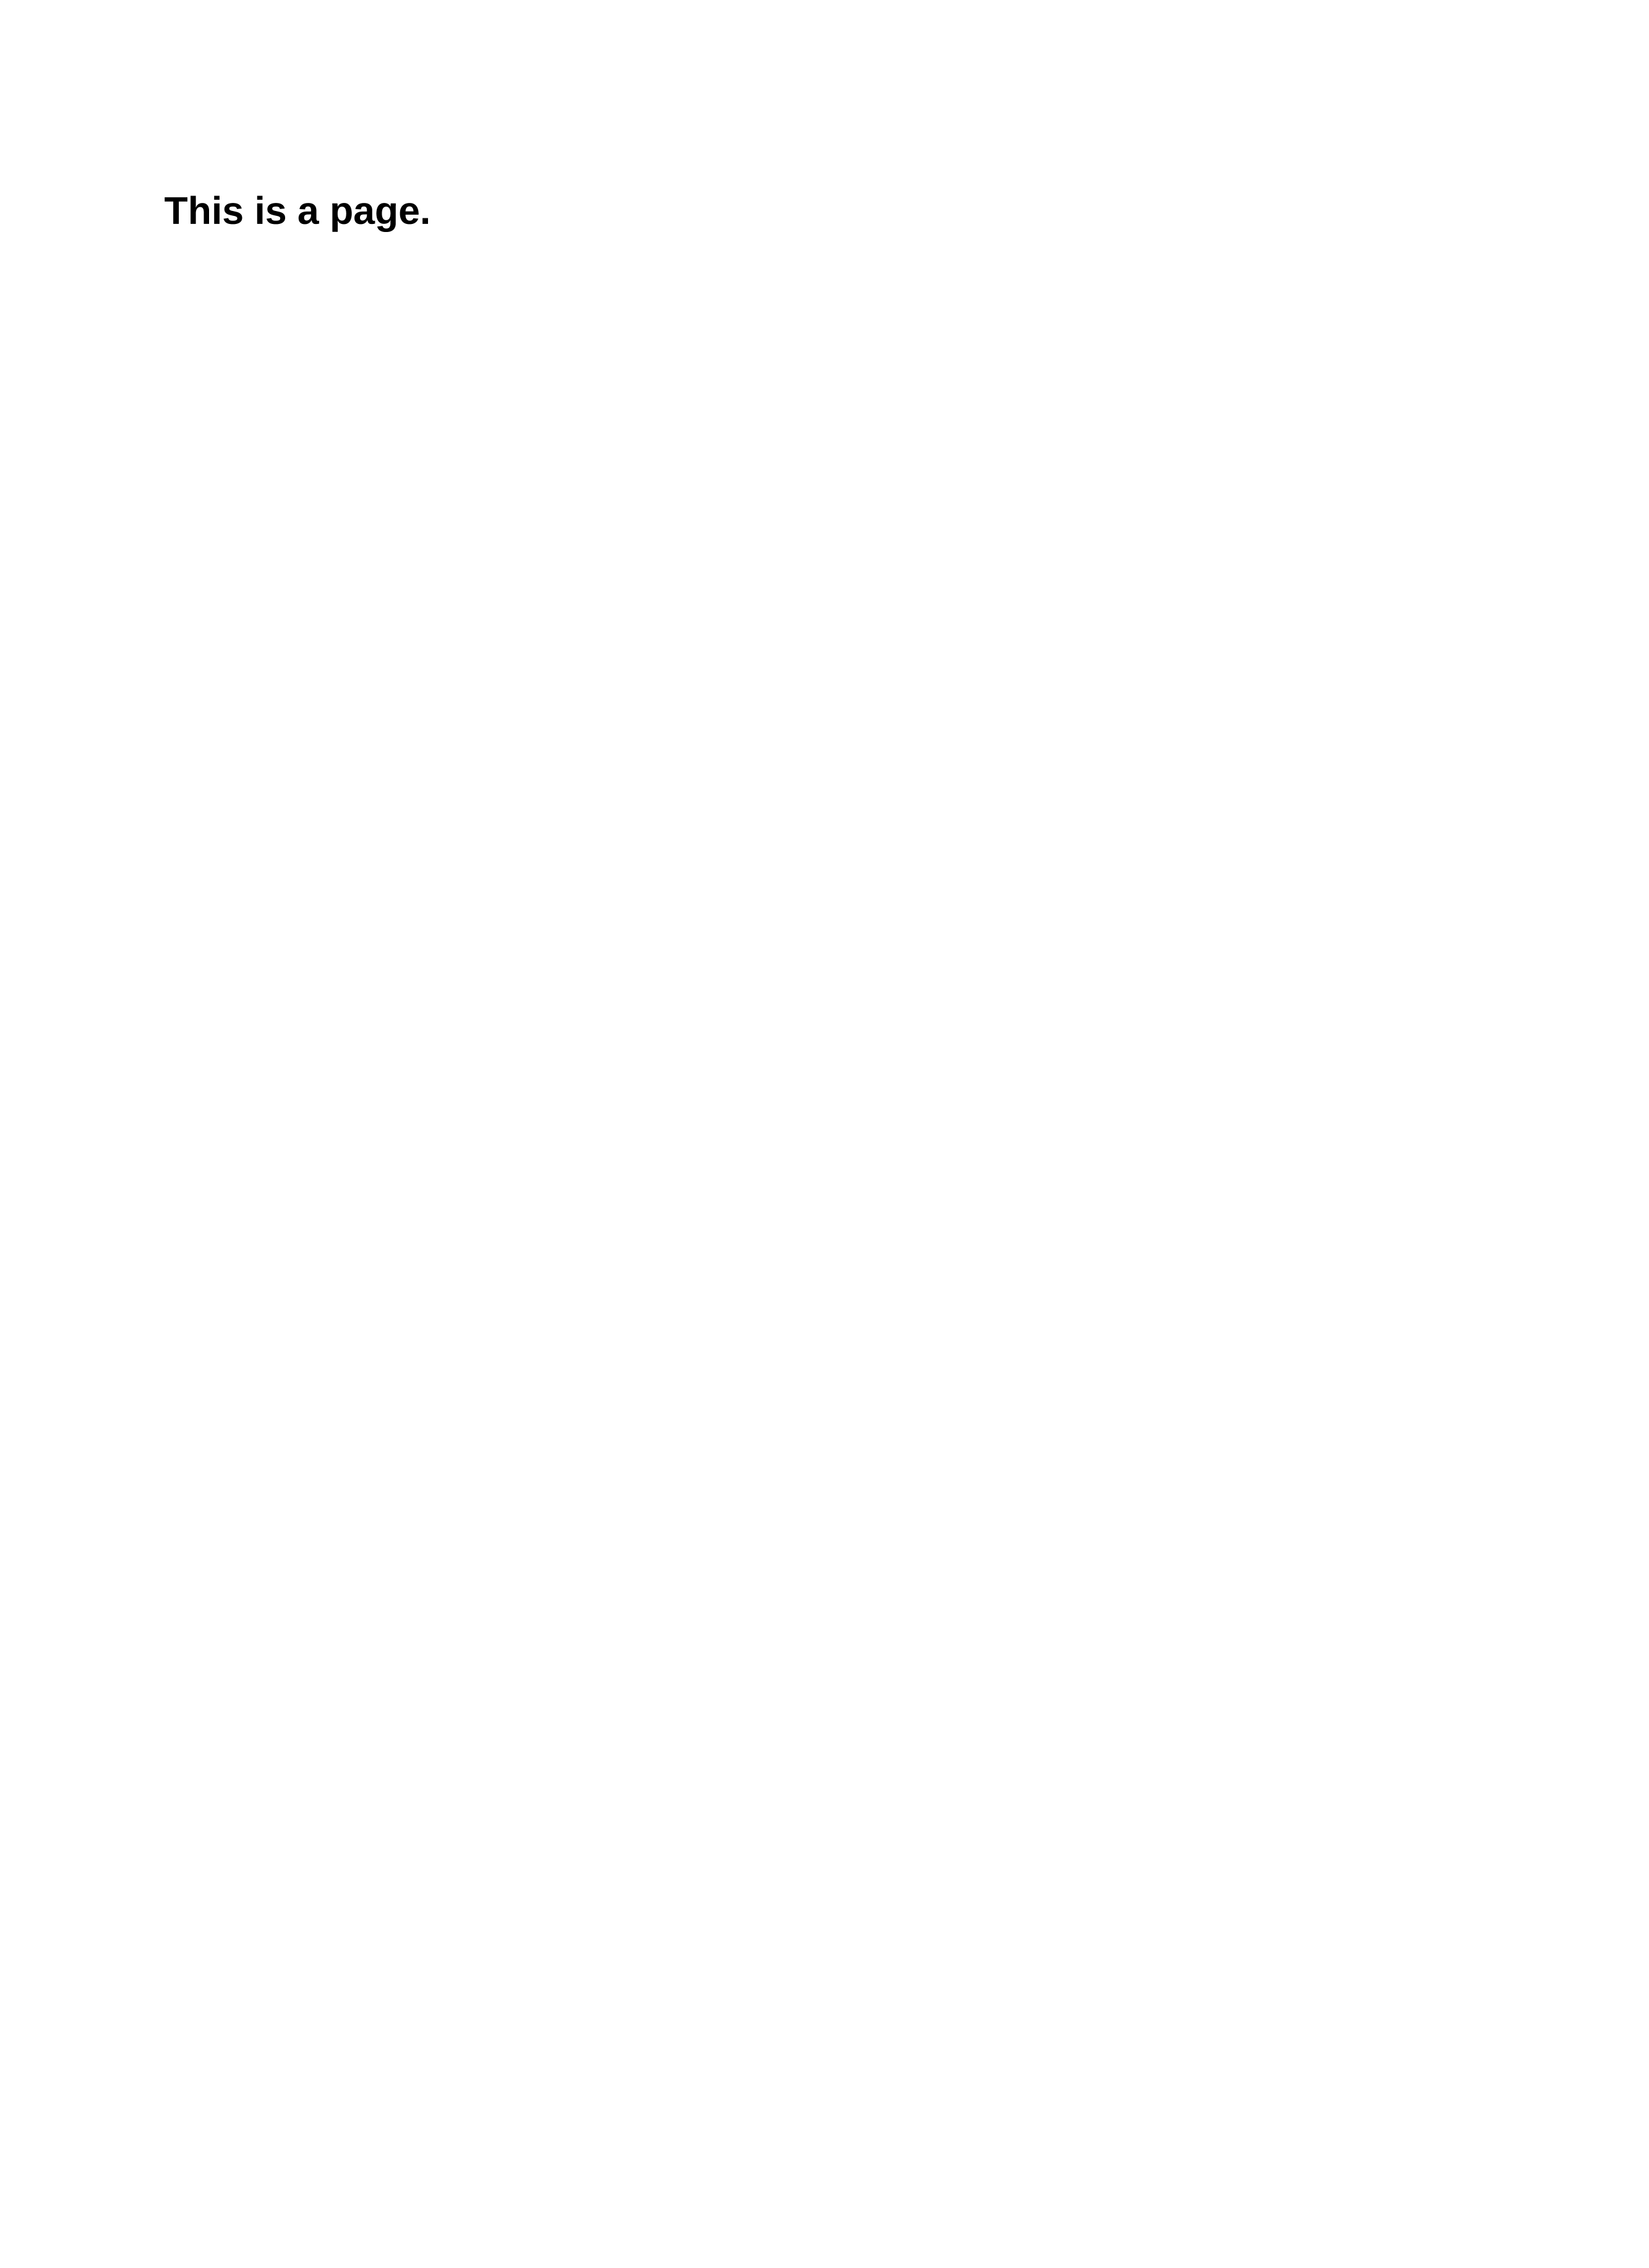


    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf
    Resolution: 300 dpi
    Width: 2666 px
    Height: 3666 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


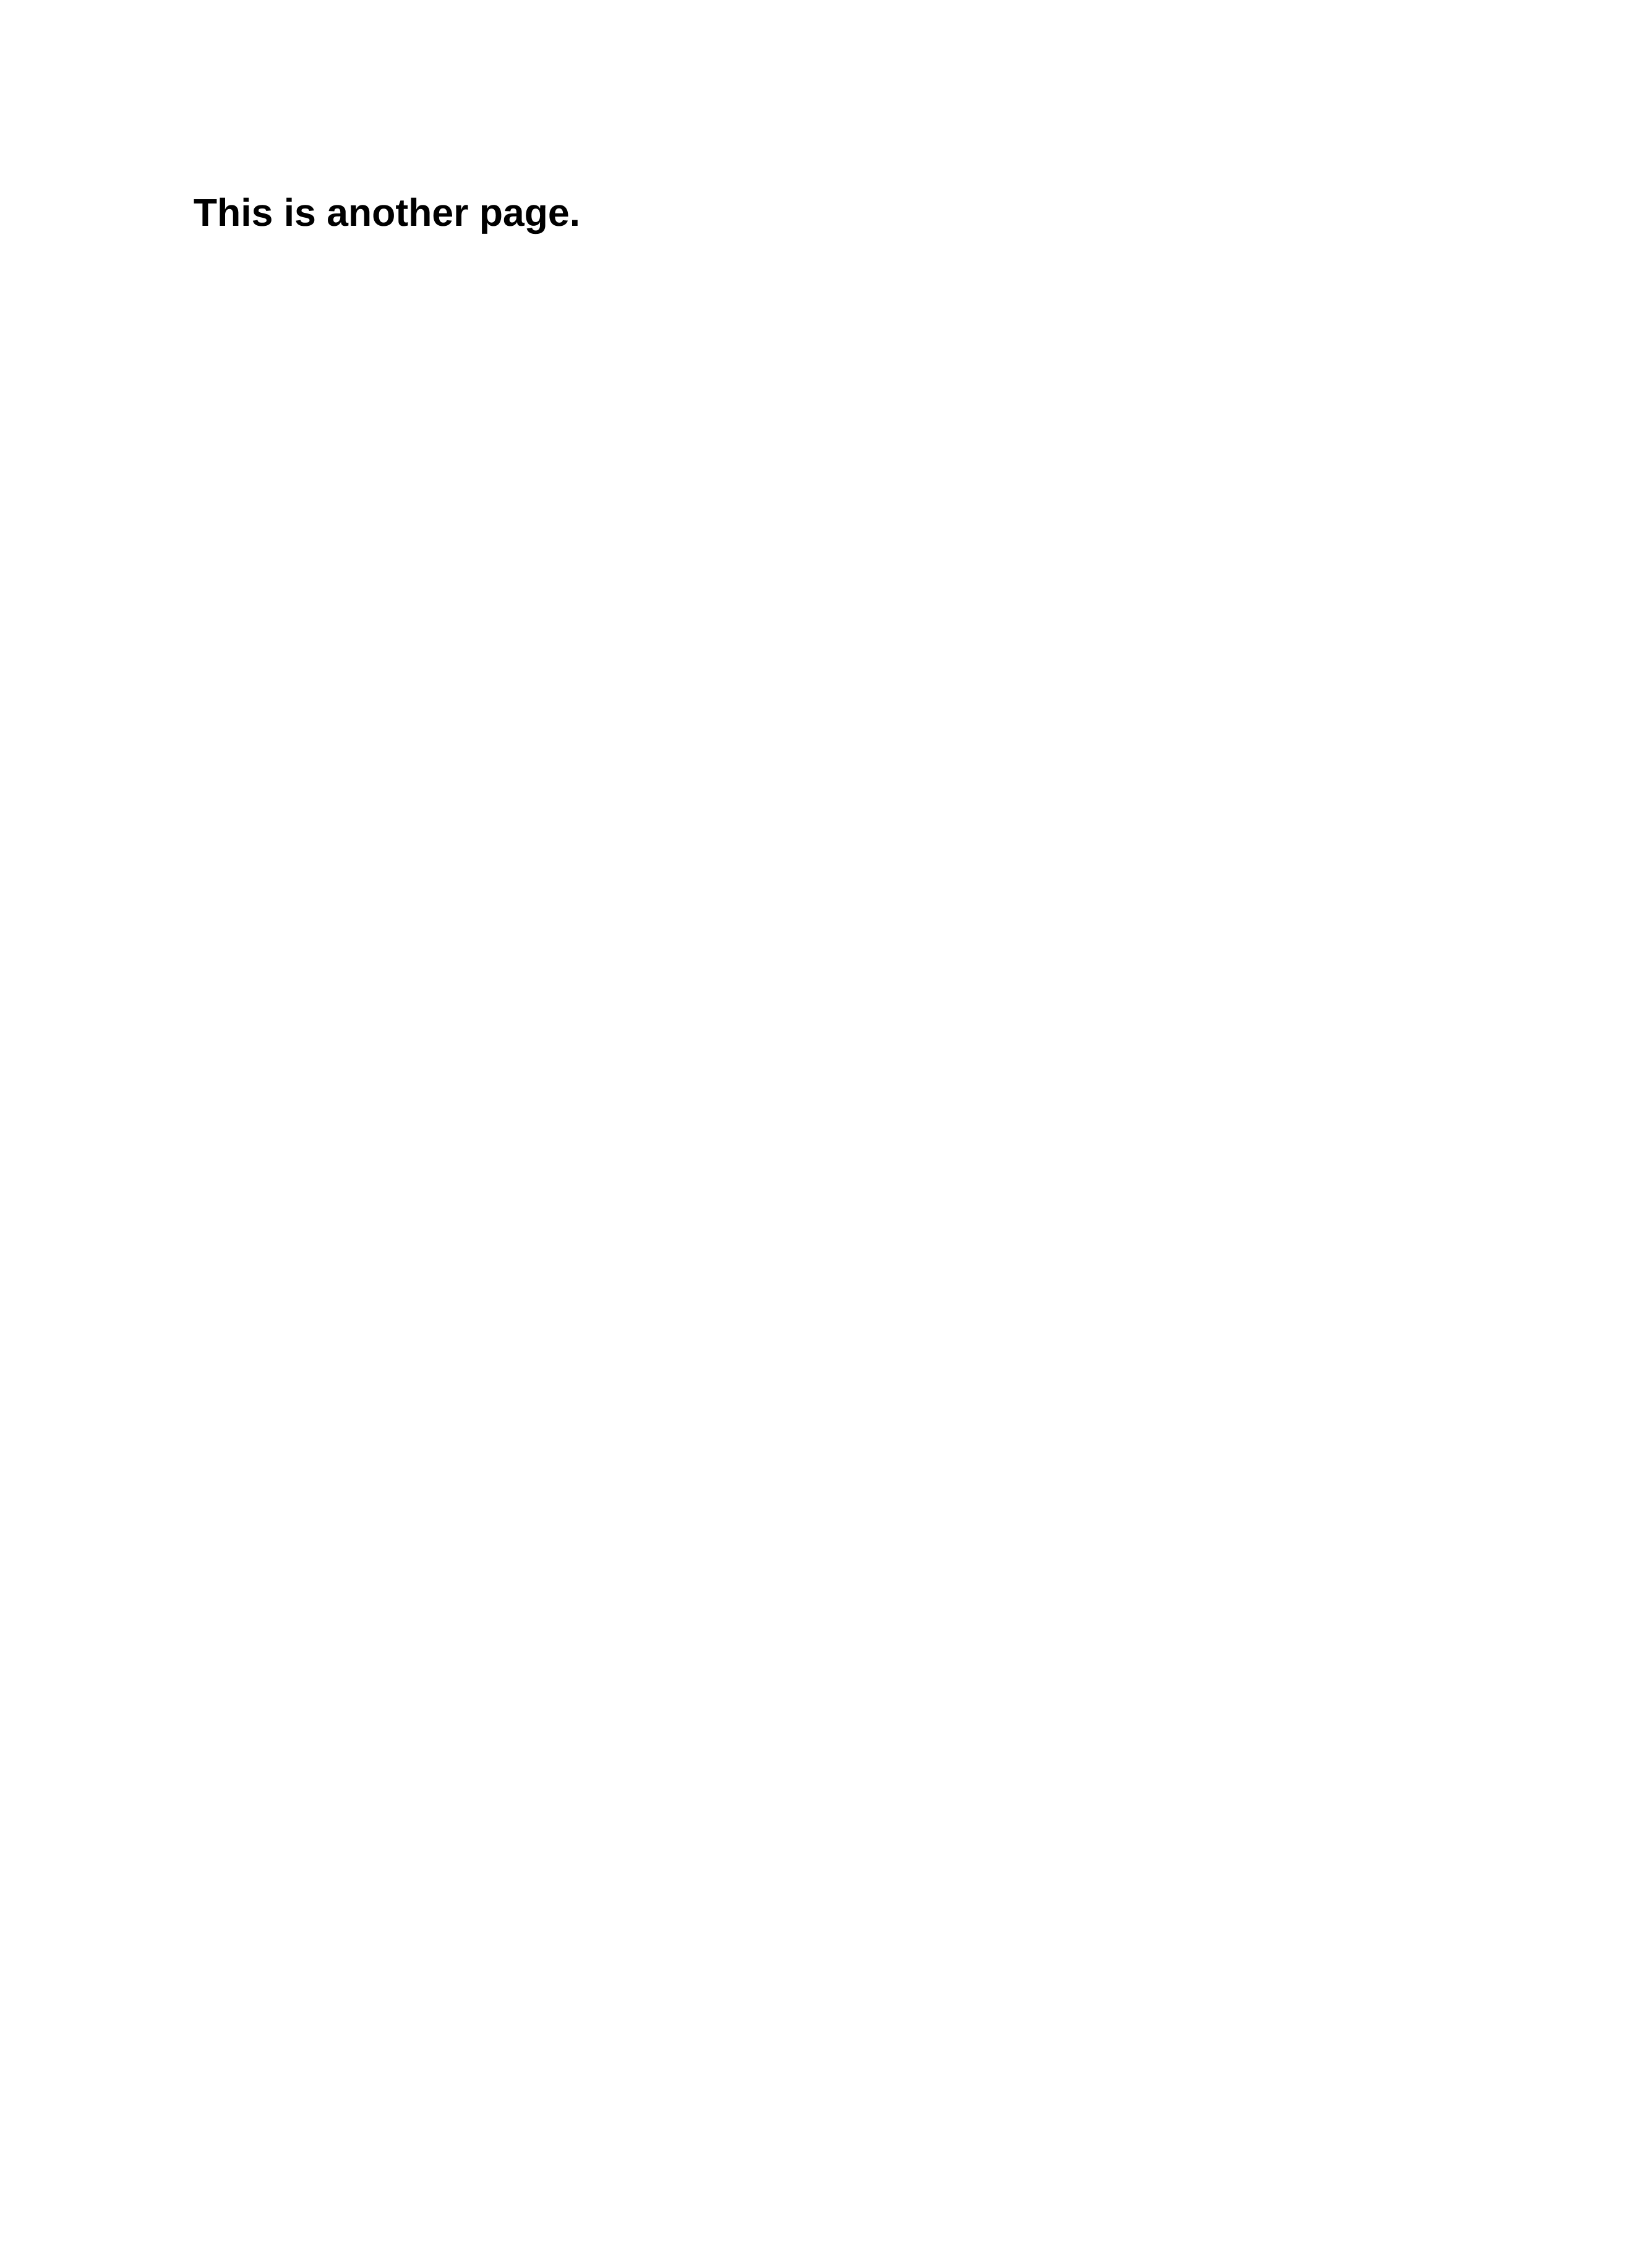


    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf
    Resolution: 300 dpi
    Width: 1 px
    Height: 1 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1



    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/image_3_pages.pdf
    Resolution: 300 dpi
    Width: 2666 px
    Height: 3666 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


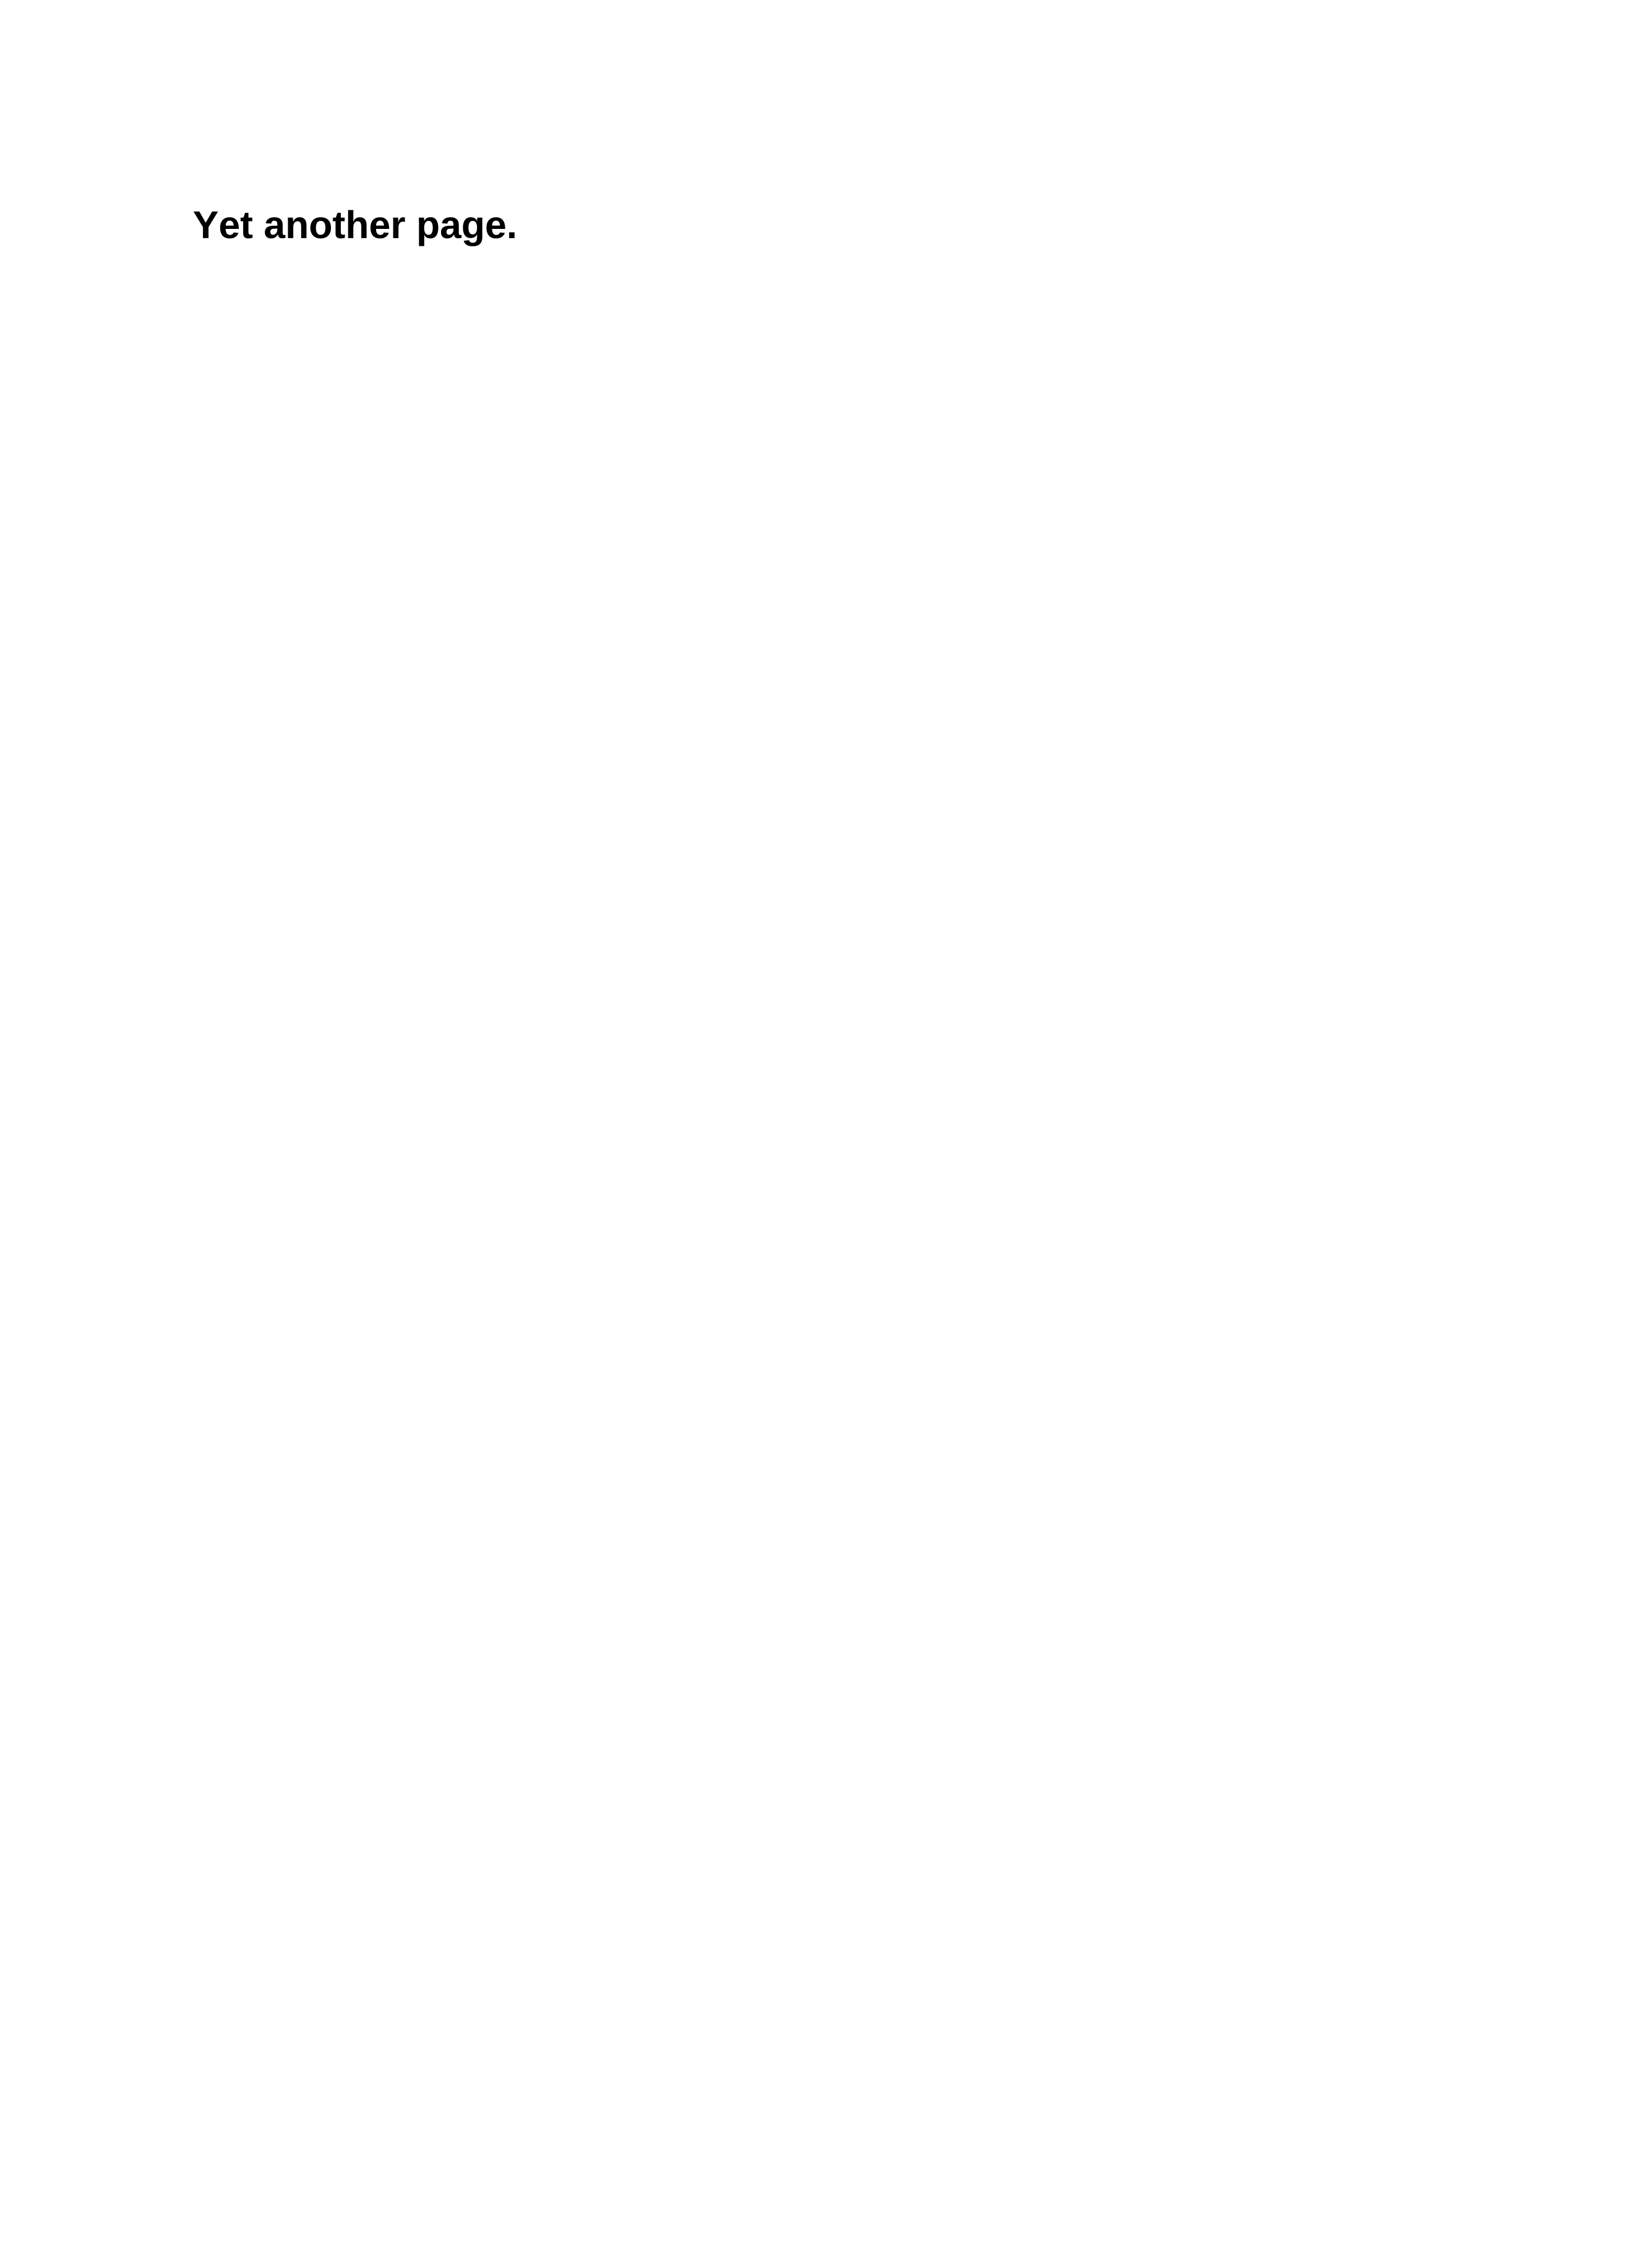


    Image #0:
    Origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/multiplepages/text_3_pages.pdf
    Resolution: 300 dpi
    Width: 1 px
    Height: 1 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


In [ ]:
image_df = PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .transform(result.select("pdf", "path"))
for r in image_df.collect():
    display_image(r.image)

In [ ]:
result.unpersist()

path,text,pdf,exception
file:/root/.local...,[Yet another page...,[25 50 44 46 2D 3...,
file:/root/.local...,[This is a page.\n],[25 50 44 46 2D 3...,
file:/root/.local...,[This is another ...,[25 50 44 46 2D 3...,
file:/root/.local...,[This is another ...,[25 50 44 46 2D 3...,
file:/root/.local...,[Yet another page...,[25 50 44 46 2D 3...,
file:/root/.local...,[This is a page.\n],[25 50 44 46 2D 3...,


In [ ]:
%%bash
rm -r -f result.pdf